# Classification showdown

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
import hparam_tune_clf as hp

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [4]:
from sklearn.datasets import make_moons

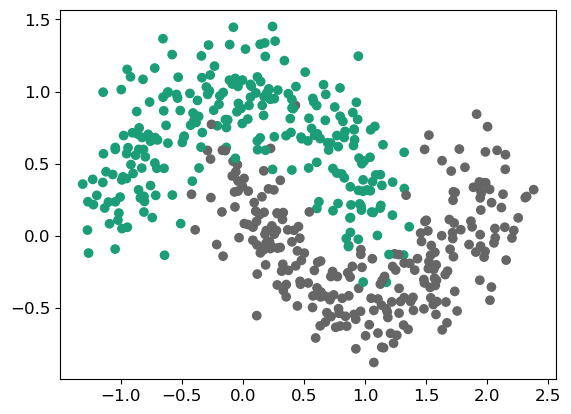

In [5]:
dataset = "moons"

n_train = 1000
n_test = 500
n_train_warmup = 200
n_test_warmup = 100

np.random.seed(314)
train = make_moons(n_samples=n_train, noise=0.2)
test = make_moons(n_samples=n_test, noise=0.2)
warmup_train = make_moons(n_samples=n_train_warmup, noise=0.2)
warmup_test = make_moons(n_samples=n_test_warmup, noise=0.2)

X_learn, y_learn = jax.tree_map(jnp.array, train)
X_test, y_test = jax.tree_map(jnp.array, test)
warmup_train = jax.tree_map(jnp.array, warmup_train)
warmup_test = jax.tree_map(jnp.array, warmup_test)

plt.scatter(*X_test.T, c=y_test, cmap="Dark2")

In [6]:
def acc_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    yhat = jnp.round(yhat)
    acc = (yhat == y_test)
    
    res = {
        "test": acc.mean(),
    }
    return res

In [7]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]    
    yhat_test = apply_fn(bel.mean, X_test).squeeze().round()
    
    # Compute errors
    y_next = y.ravel() 
    yhat_next = pred.mean.ravel()
    
    err_test = (y_test == yhat_test)
    err_pred = jnp.abs(y_next - yhat_next).sum()
    
    
    res = {
        "test": err_test.mean(),
        "osa-error": err_pred,
    }
    return res

## Test setup

In [8]:
keyv = 314
key = jax.random.PRNGKey(keyv)

```
dynamics_weights: gamma
init_cov: eta
emission_cov: r
dynamics_cov: q (steady-state assumption)
```

In [9]:
pbounds = {
    "log_init_cov": (-5, 0.0),
    "dynamics_weights": (0, 1.0),
}

In [10]:
dynamics_weights = [0.0, 0.5, 1.0] # gamma
log_init_cov = np.log([0.01, 0.1, 1.0]) # eta

elements = product(dynamics_weights, log_init_cov)
probe_points = [{
    "dynamics_weights": gamma,
    "log_init_cov": log_eta,
} for gamma, log_eta in elements]


probe_points = []
n_init_points = 0 if len(probe_points) > 0 else 10
n_gp = 15

## Model setup

In [11]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        x = nn.sigmoid(x)
        return x
    
dim_out = 1
_, dim_in = X_learn.shape
model = MLP(dim_out, activation=nn.elu)

In [12]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)

# Agent showdown

In [13]:
colors = {
    "lofi-of": "tab:blue",
    "lofi-oa": "tab:orange",
    "lofi-ff": "tab:red",
    "lofi-fa": "tab:pink",
    "orfit": "tab:green",
    "fd-ekf": "tab:purple",
    "fc-ekf": "tab:gray",
}

In [14]:
agents = {}
methods = {}
agents_beliefs = {}

## Diag-EKF

In [17]:
method = "fdekf"
agent_name= "fd-ekf"

optimizer, apply_fn, n_feats = hp.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, acc_callback, method=method
)

In [18]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | 0.5       | 0.9169    | -2.057    |
| 2         | 0.5       | 0.265     | -1.084    |
| 3         | 0.5       | 0.918     | -0.8632   |
| 4         | 0.5       | 0.728     | -3.698    |
| 5         | 0.5       | 0.9118    | -3.696    |
| 6         | 0.5       | 0.7664    | -3.692    |
| 7         | 0.5       | 0.1223    | -3.07     |
| 8         | 0.5       | 0.8401    | -3.609    |
| 9         | 0.5       | 0.06991   | -1.834    |
| 10        | 0.5       | 0.5848    | -2.094    |
| 11        | 0.5       | 0.02274   | -0.004129 |
| 12        | 0.5       | 0.01227   | -4.988    |
| 13        | 0.84      | 0.9943    | -0.005725 |
| 14        | 0.5       | 0.8101    | 0.0       |
| 15        | 0.85      | 0.9995    | -0.05781  |
| 16        | 0.85      | 1.0       | -0.2018   |
| 17        | 0.5       | 0.7032    | -3.891    |
| 18        | 0.5       | 0.8322    | -4.716    |


In [19]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp.get_best_params(n_params, optimizer, method=method)
estimator = hp.build_estimator(flat_params, hparams, apply_fn, method=method)
bel, output = estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)


agents[agent_name] = estimator
methods[agent_name] = output
agents_beliefs[agent_name] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.8600


## LoFi (orth / fixed)

In [20]:
method = "orth_svd_lofi"
agent_name = "lofi-of"

params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

optimizer, apply_fn, n_features = hp.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, acc_callback, method=method,
    params_lofi=params_lofi
)

In [21]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | 0.5       | 0.9169    | -2.057    |
| 2         | 0.5       | 0.265     | -1.084    |
| 3         | 0.5       | 0.918     | -0.8632   |
| 4         | 0.5       | 0.728     | -3.698    |
| 5         | 0.5       | 0.9118    | -3.696    |
| 6         | 0.5       | 0.7664    | -3.692    |
| 7         | 0.5       | 0.1223    | -3.07     |
| 8         | 0.5       | 0.8401    | -3.609    |
| 9         | 0.5       | 0.06991   | -1.834    |
| 10        | 0.5       | 0.5848    | -2.094    |
| 11        | 0.5       | 0.02274   | -0.004129 |
| 12        | 0.5       | 0.01227   | -4.988    |
| 13        | 0.83      | 0.9943    | -0.005725 |
| 14        | 0.5       | 0.8101    | 0.0       |
| 15        | 0.84      | 0.9995    | -0.05781  |
| 16        | 0.84      | 1.0       | -0.2017   |
| 17        | 0.5       | 0.7032    | -3.891    |
| 18        | 0.5       | 0.8322    | -4.716    |


In [23]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp.get_best_params(n_params, optimizer, method=method)
estimator = hp.build_estimator(
    flat_params, hparams, apply_fn, method=method, orfit_params=params_lofi
)
bel, output = estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[agent_name] = estimator
methods[agent_name] = output
agents_beliefs[agent_name] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.8200


## LoFi (full / fixed)

In [24]:
method = "full_svd_lofi"
agent_name = "lofi-ff"

params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

optimizer, apply_fn, n_features = hp.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, acc_callback, method=method,
    params_lofi=params_lofi
)

In [25]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | 0.5       | 0.9169    | -2.057    |
| 2         | 0.5       | 0.265     | -1.084    |
| 3         | 0.5       | 0.918     | -0.8632   |
| 4         | 0.5       | 0.728     | -3.698    |
| 5         | 0.5       | 0.9118    | -3.696    |
| 6         | 0.5       | 0.7664    | -3.692    |
| 7         | 0.5       | 0.1223    | -3.07     |
| 8         | 0.5       | 0.8401    | -3.609    |
| 9         | 0.5       | 0.06991   | -1.834    |
| 10        | 0.5       | 0.5848    | -2.094    |
| 11        | 0.5       | 0.02274   | -0.004129 |
| 12        | 0.5       | 0.01227   | -4.988    |
| 13        | 0.86      | 0.9943    | -0.005725 |
| 14        | 0.5       | 0.8101    | 0.0       |
| 15        | 0.91      | 0.9995    | -0.05781  |
| 16        | 0.92      | 1.0       | -0.1822   |
| 17        | 0.5       | 0.7032    | -3.891    |
| 18        | 0.5       | 0.8322    | -4.716    |


In [26]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp.get_best_params(n_params, optimizer, method=method)
estimator = hp.build_estimator(
    flat_params, hparams, apply_fn, method=method, orfit_params=params_lofi
)
bel, output = estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[agent_name] = estimator
methods[agent_name] = output
agents_beliefs[agent_name] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.9600


## FC-EKF

In [27]:
method = "fcekf"
agent_name = "fc-ekf"

optimizer, apply_fn, n_features = hp.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, acc_callback, method=method
)

In [28]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | 0.5       | 0.9169    | -2.057    |
| 2         | 0.5       | 0.265     | -1.084    |
| 3         | 0.5       | 0.918     | -0.8632   |
| 4         | 0.5       | 0.728     | -3.698    |
| 5         | 0.5       | 0.9118    | -3.696    |
| 6         | 0.5       | 0.7664    | -3.692    |
| 7         | 0.5       | 0.1223    | -3.07     |
| 8         | 0.5       | 0.8401    | -3.609    |
| 9         | 0.5       | 0.06991   | -1.834    |
| 10        | 0.5       | 0.5848    | -2.094    |
| 11        | 0.5       | 0.02274   | -0.004129 |
| 12        | 0.5       | 0.01227   | -4.988    |
| 13        | 0.86      | 0.9943    | -0.005725 |
| 14        | 0.5       | 0.8101    | 0.0       |
| 15        | 0.91      | 0.9995    | -0.05781  |
| 16        | 0.92      | 1.0       | -0.1822   |
| 17        | 0.5       | 0.7032    | -3.891    |
| 18        | 0.5       | 0.8322    | -4.716    |


In [29]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp.get_best_params(n_params, optimizer, method="fcekf")
estimator = hp.build_estimator(flat_params, hparams, apply_fn, method="fcekf")
bel, output = estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[agent_name] = estimator
methods[agent_name] = output
agents_beliefs[agent_name] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.9620


## Plot results

In [30]:
%%time
methods = jax.tree_map(np.array, methods)

CPU times: user 1.2 ms, sys: 4.1 ms, total: 5.3 ms
Wall time: 3.29 ms


In [47]:
data = {
    key: methods[key]["test"]
    for key in methods
}

data = pd.DataFrame(data)

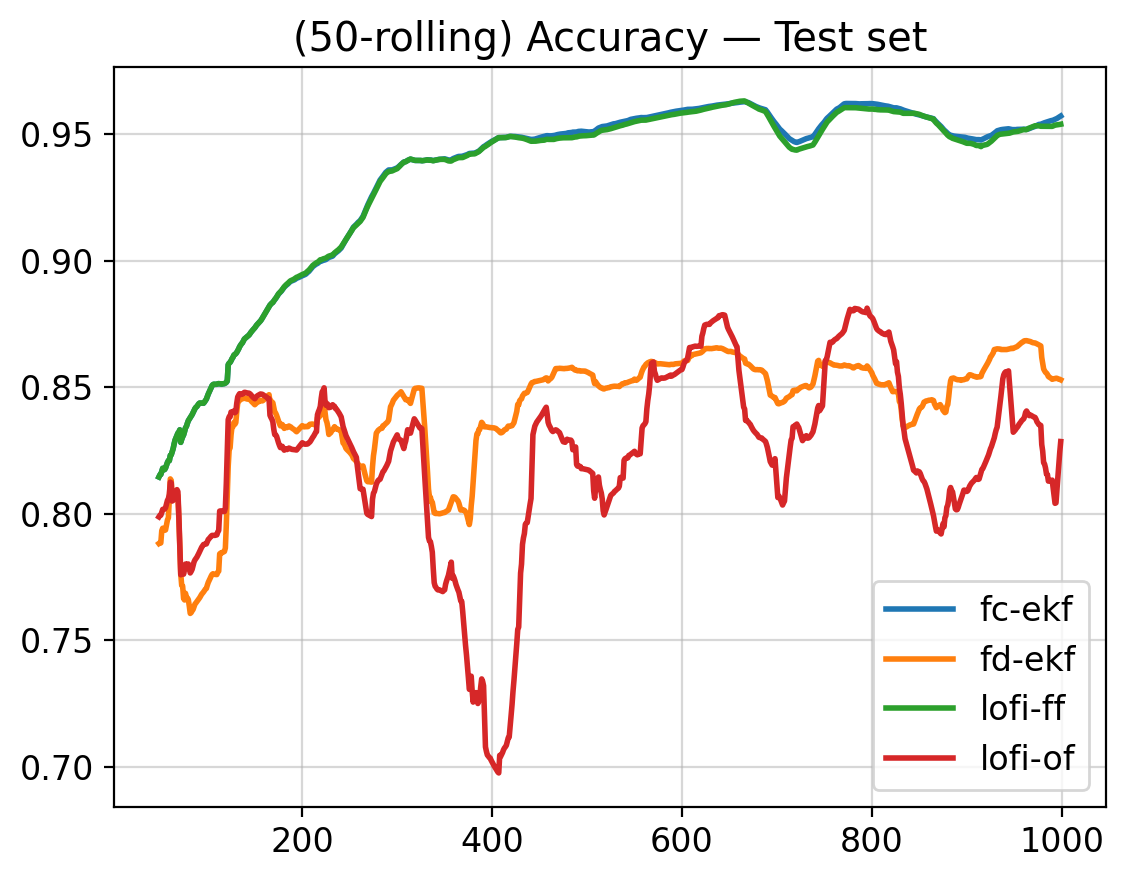

In [48]:
data.rolling(50).mean().plot()
plt.title(f"(50-rolling) Accuracy — Test set")
plt.grid(alpha=0.5)

# Simulations

In [33]:
def eval_runs(key, num_runs_pc, estimator):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = estimator.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [34]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [35]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 2 * std_sim
    ubound = mean_sim + 2 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

## Run simulations

In [36]:
sims = {}
n_agents = len(agents)
for name, agent in tqdm(agents.items(), total=n_agents):
    res = eval_runs(key, num_runs_pc=5, estimator=agent)
    sims[name] = jax.tree_map(np.array, res)

  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
jax.tree_map(np.shape, sims)

{'fc-ekf': {'osa-error': (40, 1000), 'test': (40, 1000)},
 'fd-ekf': {'osa-error': (40, 1000), 'test': (40, 1000)},
 'lofi-ff': {'osa-error': (40, 1000), 'test': (40, 1000)},
 'lofi-of': {'osa-error': (40, 1000), 'test': (40, 1000)}}

## Plots

### Plot rolling RMAE on the test set

In [49]:
collection = {
    agent: pd.DataFrame(res["test"]).T
    for agent, res in sims.items()
}

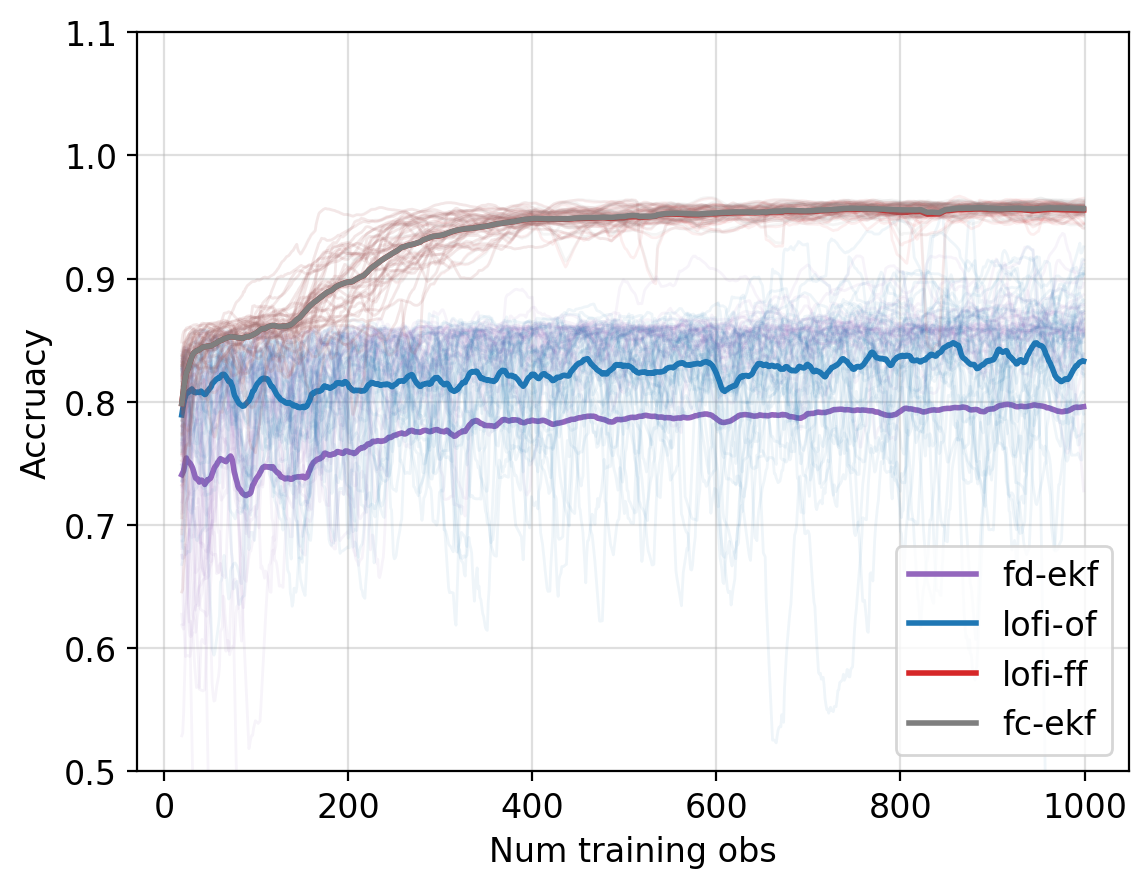

In [50]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=20)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("Accruacy")
plt.ylim(0.5, 1.1)
plt.savefig(f"output/bounds-{dataset}.pdf")

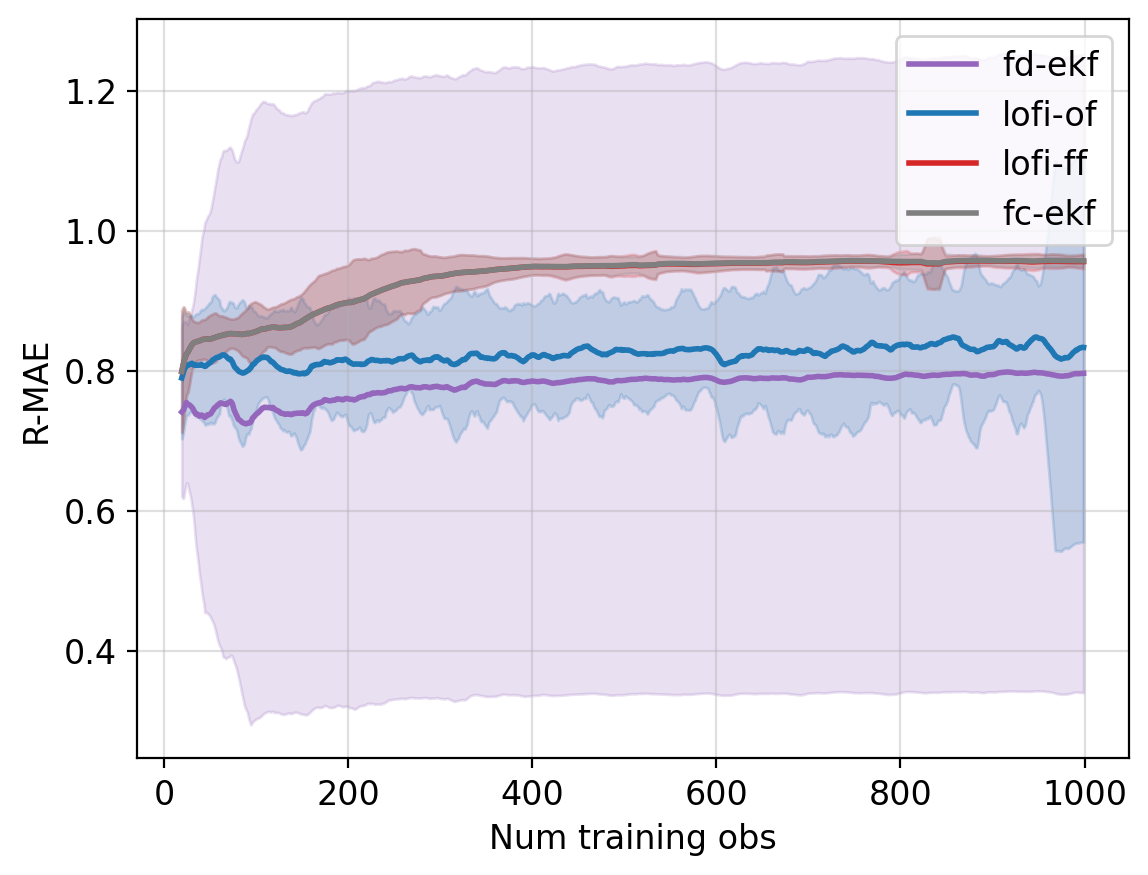

In [51]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=20)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

In [52]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

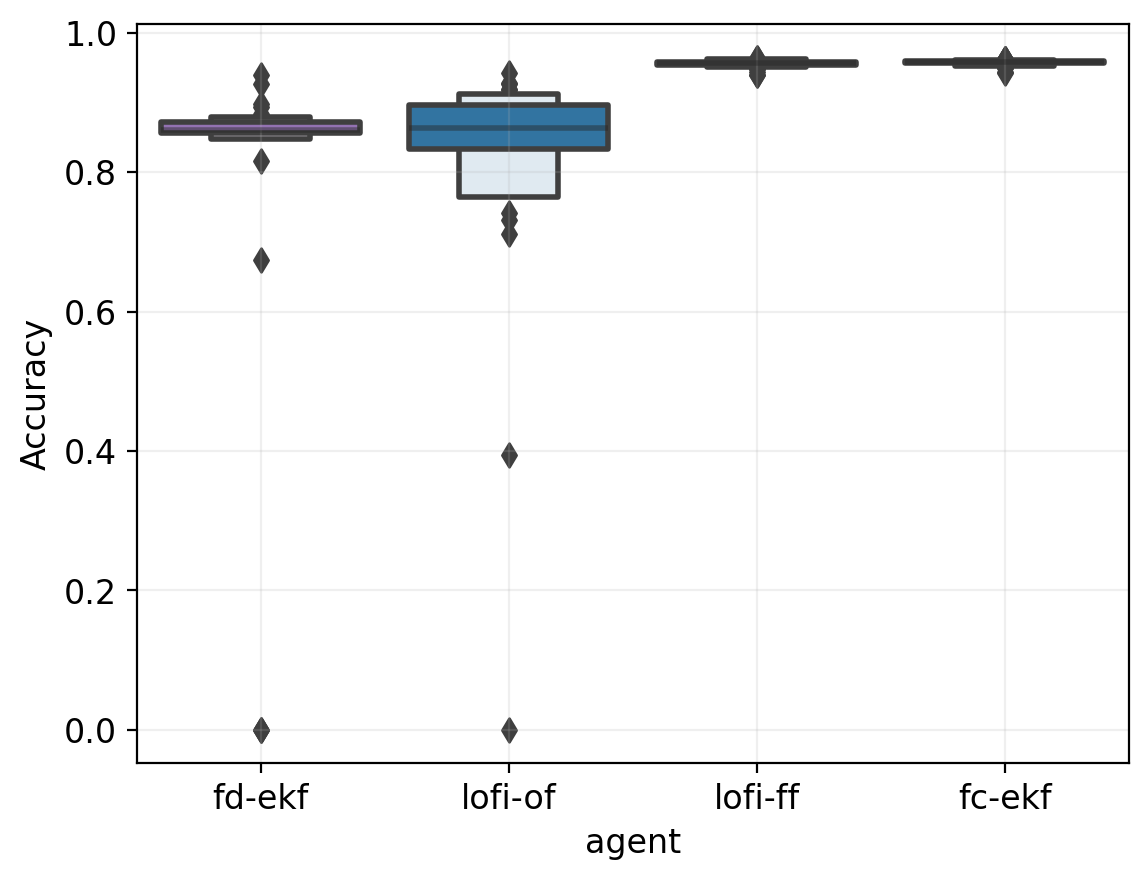

In [53]:
sns.boxenplot(
    x="agent",
    y="Accuracy",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="Accuracy")
)
plt.grid(alpha=0.2)
plt.savefig(f"output/last-metric-{dataset}.pdf")

### Plot rolling RMAE on the one-step-ahead posterior predictive

In [54]:
collection = {
    agent: pd.DataFrame(res["osa-error"]).T
    for agent, res in sims.items()
}

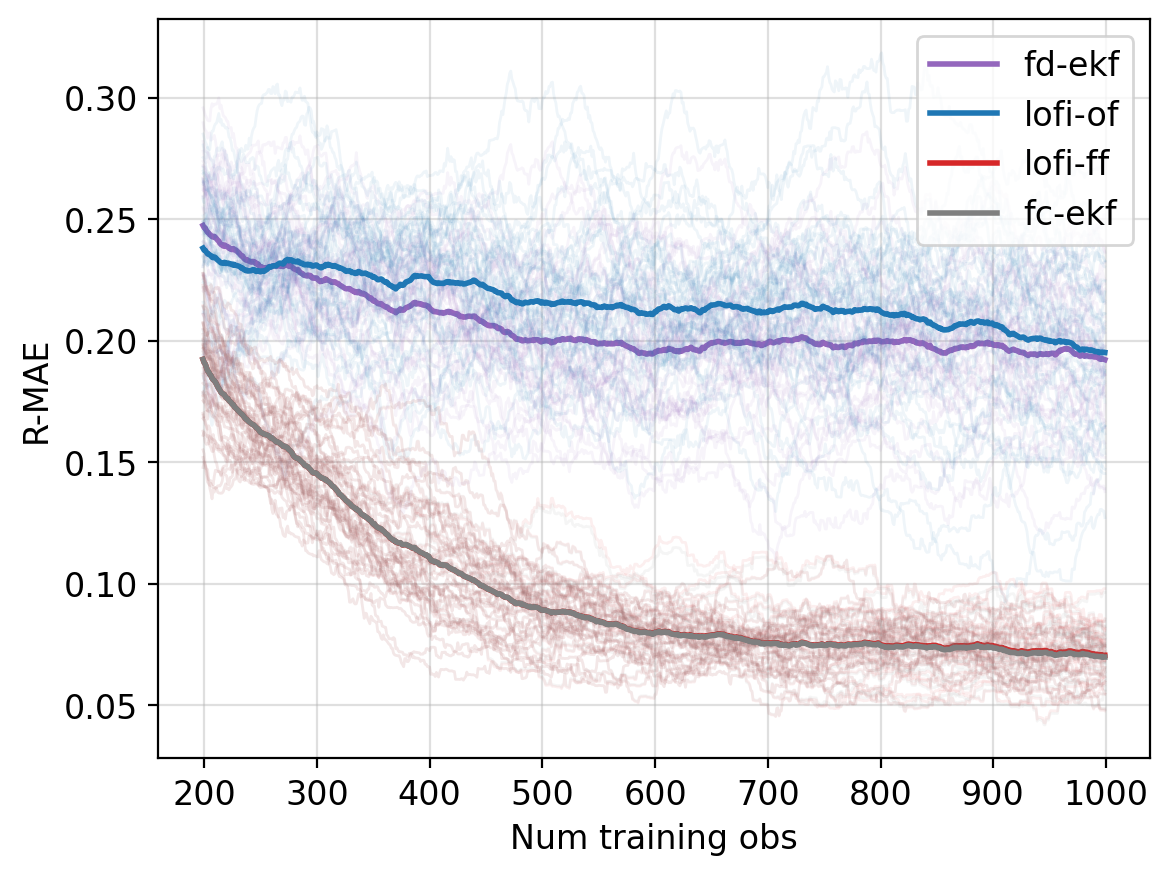

In [55]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")

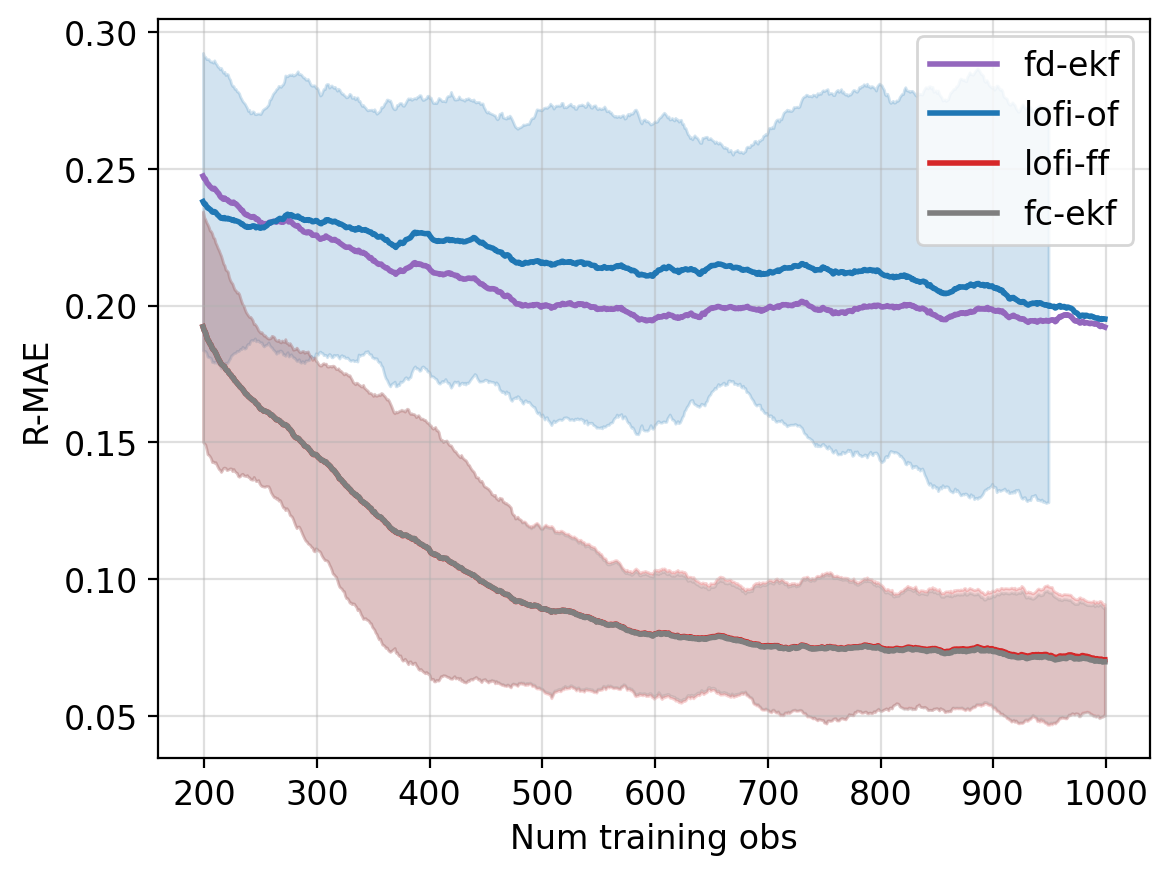

In [56]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-bounds-{dataset}.pdf")

## Posterior predictive plots

In [57]:
vminx, vminy = X_test.min(axis=0) * 1.05
vmaxx, vmaxy = X_test.max(axis=0) * 1.05

range1 = slice(vminx, vmaxx, 0.1)
range2 = slice(vminy, vmaxy, 0.1)

In [58]:
xgrid = jnp.mgrid[range1, range2]

In [61]:
vapply = jax.vmap(apply_fn, in_axes=(None, 1), out_axes=0)
vapply = jax.vmap(vapply, in_axes=(None, 2), out_axes=1)

mean = agents_beliefs["fd-ekf"].mean
z = vapply(mean, xgrid).squeeze()

(-1.3761965036392212, 2.42380428314209, -0.9218019843101501, 1.478198528289795)

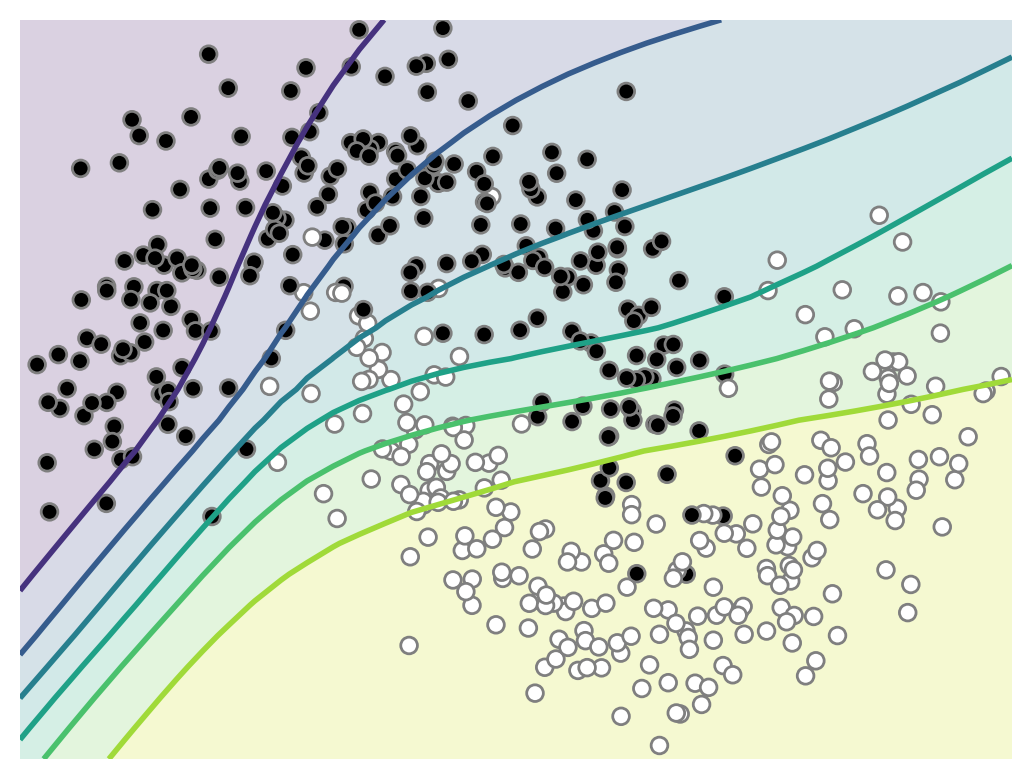

In [62]:
cmap = "viridis"
plt.contourf(*xgrid, z, cmap=cmap, alpha=0.2)
plt.contour(*xgrid, z, cmap=cmap)
plt.scatter(*X_test.T, c=y_test, cmap="bone", edgecolor="tab:gray", linewidth=1.0)
plt.axis("off")

In [75]:
%%capture
for agent, bel in agents_beliefs.items():
    fig, ax = plt.subplots()
    mean = bel.mean
    z = vapply(mean, xgrid).squeeze()
    cmap = "viridis"
    plt.contourf(*xgrid, z, cmap=cmap, alpha=0.2)
    plt.contour(*xgrid, z, cmap=cmap)
    plt.scatter(*X_test.T, c=y_test, cmap="bone", edgecolor="tab:gray", linewidth=1.0)
    plt.axis("off")
    plt.savefig(f"./output/{agent}-{dataset}-contours.pdf")